<a href="https://colab.research.google.com/github/ThisuriLekamge/Stock-Price-Prediction-on-Bitcoin-trading-data-using-LSTM-with-PyTorch/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import glob
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch


In [5]:
#print("python version %s"% python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

pandas==0.25.3
numpy==1.17.4
sklearn==0.21.3
torch==1.3.1
matplotlib==3.1.2


In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"]="w"

**Now download data from BitMex** (The Bitcoin Mercantile Exchange) -> https://www.bitmex.com/app/trade/XBTUSD

**Retrieve bitmex/binance data**
link - https://github.com/BitMEX/easy-data-scripts

https://medium.com/swlh/retrieving-full-historical-data-for-every-cryptocurrency-on-binance-bitmex-using-the-python-apis-27b47fd8137f



In [3]:
from google.colab import files
uploaded = files.upload()

Saving XBTUSD-5m-data.csv to XBTUSD-5m-data.csv


In [0]:
df = pd.read_csv("./XBTUSD-5m-data.csv")

In [5]:
df.shape


(444941, 13)

In [0]:
df.timestamp = pd.to_datetime(df.timestamp.str.replace('D', 'T'))
df = df.sort_values('timestamp')


In [0]:
df.set_index('timestamp', inplace=True) #set to index


In [8]:
df.head()

,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
timestamp,,,,,,,,,,,,
2015-09-25 12:05:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:10:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:15:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:20:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0
2015-09-25 12:25:00+00:00,XBTUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.0,0.0


In [9]:
df.tail()

,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
timestamp,,,,,,,,,,,,
2019-12-18 10:05:00+00:00,XBTUSD,6626.5,6627.0,6618.5,6619.5,1867,7701044,6622.0780,50.0,116300429523,1163.004295,7701044.0
2019-12-18 10:10:00+00:00,XBTUSD,6619.5,6623.5,6615.5,6615.5,1395,4672540,6621.2011,622.0,70573830493,705.738305,4672540.0
2019-12-18 10:15:00+00:00,XBTUSD,6615.5,6640.0,6610.0,6629.0,3925,14074759,6628.2230,133.0,212353244058,2123.532441,14074759.0
2019-12-18 10:20:00+00:00,XBTUSD,6629.0,6668.0,6629.0,6643.0,5777,20318419,6648.9362,49917.0,305603710118,3056.037101,20318419.0
2019-12-18 10:25:00+00:00,XBTUSD,6643.0,6643.0,6631.5,6631.5,2070,6060225,6636.1404,2000.0,91325461378,913.254614,6060225.0


The data representation where we group trades by the predefined time interval is called time bars.
https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089

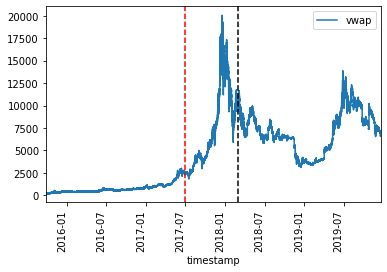

In [10]:

ax = df.plot(y="vwap",rot = 90)
ax.axvline("2018-03-01", linestyle="--", c="black")
ax.axvline("2017-07-01", linestyle="--", c='red')

In [11]:
df_vwap = df.loc[:,["vwap"]]
df_vwap.tail()

,vwap
timestamp,
2019-12-18 10:05:00+00:00,6622.0780
2019-12-18 10:10:00+00:00,6621.2011
2019-12-18 10:15:00+00:00,6628.2230
2019-12-18 10:20:00+00:00,6648.9362
2019-12-18 10:25:00+00:00,6636.1404


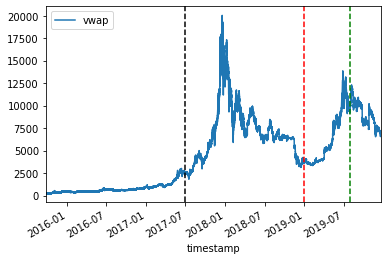

In [12]:
ax = df_vwap.plot()
ax.axvline("2017-07-01", linestyle="--", c="black")
ax.axvline("2019-01-01", linestyle="--", c='red')
ax.axvline("2019-08-01", linestyle="--", c='green')
#ax.fill_between(color='grey') #Bollinger band

Bollinger band -> https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300

In [13]:
df_train = df_vwap[(df_vwap.index >= "2017-07-01")&(df_vwap.index <= "2019-01-01")]
df_train.shape

(158113, 1)

In [14]:
df_valid = df_vwap[(df_vwap.index >= "2019-01-01")&(df_vwap.index <= "2019-07-01")]
df_valid.shape

(52129, 1)

In [15]:
df_test = df_vwap[df_vwap.index < "2019-07-01"]
df_test.shape

(395855, 1)

Data Scaling

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_set = scaler.fit_transform(df_train)
test_set = scaler.fit_transform(df_test)
valid_set = scaler.fit_transform(df_valid)


In [17]:
print(len(train_set))

158113


Data Transforming

Here the feature and the target are from the same sequence. the only difference is that the target is shifted by 1 time bar.

Here we transform the long sequence of data into many shorter sequences (100 time bars per sequence) that are shifted by a single time bar.

In [0]:
from torch.autograd import Variable

def transform_data(arr, seq_len):
  x,y = [],[]
  for i in range(len(arr)-seq_len):
    x_i = arr[i: i+seq_len]
    y_i = arr[i+1:i+seq_len+1]
    x.append(x_i)
    y.append(y_i)

  x_arr = np.array(x).reshape(-1,seq_len)
  y_arr = np.array(y).reshape(-1,seq_len)
  x_var = Variable(torch.from_numpy(x_arr).float())#inputs
  y_var = Variable(torch.from_numpy(y_arr).float())
  return x_var,y_var


In [0]:
seq_len =100

x_train, y_train = transform_data(train_set, seq_len)
x_val, y_val = transform_data(valid_set,seq_len)
x_test, y_test = transform_data(test_set,seq_len)

In [0]:
def plot_sequence(axes, i, x_train, y_train):
  axes[i].set_title("%d. sequence"%(i+1))
  axes[i].set_xlabel("Time Bars")
  axes[i].set_ylabel("Scales VWAP")
  axes[i].plot(range(seq_len),x_train[i].cpu().numpy(), color='r', label='Feature') #converting Variable to numpy
  axes[i].plot(range(1,seq_len+1), y_train[i].cpu().numpy(), color='b', label='Target')
  axes[i].legend()


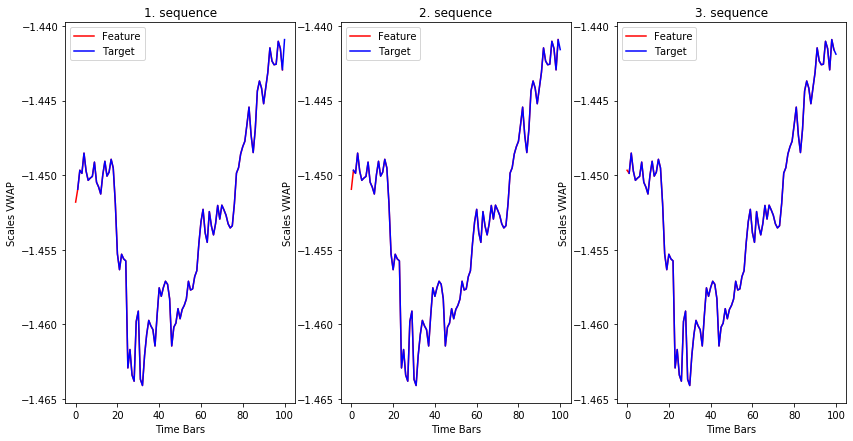

In [21]:
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(14,7))
plot_sequence(axes,0,x_train,y_train)
plot_sequence(axes,1,x_train,y_train)
plot_sequence(axes,2,x_train,y_train)

LSTM

In [0]:
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Model, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
    self.linear = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, future=0, y=None):
    outputs = []

    #reset the state of LSTM
    #the state is kept till the end of the sequence
    h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
    c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

    for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
      h_t, c_t = self.lstm(input_t, (h_t,c_t))
      output = self.linear(h_t)
      outputs += [output]

    for i in range





  